<a href="https://colab.research.google.com/github/shivaansh81001/btc-prediction/blob/main/btc_data_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from datascience import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path='/content/drive/MyDrive/btc predict/'

In [4]:
TABLE_NAME='btcusd_1-min_data.csv'
data=Table().read_table(path+TABLE_NAME)
data.show(5)

Timestamp,Open,High,Low,Close,Volume
1.32541e+09,4.58,4.58,4.58,4.58,0
1.32541e+09,4.58,4.58,4.58,4.58,0
1.32541e+09,4.58,4.58,4.58,4.58,0
1.32541e+09,4.58,4.58,4.58,4.58,0
1.32541e+09,4.58,4.58,4.58,4.58,0


In [5]:
def format_price(price):
  split_=price.split(',')
  return float(split_[0]+split_[1])

def format_vol(vol):
  split_=float(vol[:-1])*1000
  return split_

def format_change(change):
  return float(change[:-1])

def format_time(time):
  time=int(time)
  return str(datetime.utcfromtimestamp(time).strftime('%Y-%m-%d %H:%M:%S'))

def sum_volume_1h(vol):
  return [sum(vol[i:i+60]) for i in range(2, len(vol), 60)]

def calc_rsi(data ,period=14):
  delta= data.diff(1)
  gain= (delta.where(delta>0,0)).rolling(window=period).mean()
  loss= (-delta.where(delta<0,0)).rolling(window=period).mean()
  rs= gain/loss
  return 100- (100/(1+rs))

def calc_rsi_condition(rsi):
  condition=[]
  for i in rsi:
    if i>=70:
      condition.append(1)
    elif i<30:
      condition.append(-1)
    elif i>=30 and i<70:
      condition.append(0)
  return np.array(condition)

In [6]:
volsum_1h= sum_volume_1h(list(data.column("Volume")))

In [7]:
#volsum len
print(len(volsum_1h))

112355


In [8]:
#test format_price
print(format_price('95,284.5'))

#test format_vol
print(format_vol('61.62K'))

#test format_time
print(format_time(1734447660))

#vol sum
print(sum_volume_1h([x for x in range(1,361)]))

95284.5
61620.0
2024-12-17 15:01:00
[1950, 5550, 9150, 12750, 16350, 19227]


In [10]:
data= data.to_df()
data= data.dropna(inplace=False)
data= Table().from_df(data)


In [11]:
formatted_time = data.apply(format_time,"Timestamp")
data = data.with_column("Timestamp",formatted_time)

data.show(5)

Timestamp,Open,High,Low,Close,Volume
2012-01-01 10:01:00,4.58,4.58,4.58,4.58,0
2012-01-01 10:02:00,4.58,4.58,4.58,4.58,0
2012-01-01 10:03:00,4.58,4.58,4.58,4.58,0
2012-01-01 10:04:00,4.58,4.58,4.58,4.58,0
2012-01-01 10:05:00,4.58,4.58,4.58,4.58,0


In [12]:
data= data.take(np.arange(2,data.num_rows,60))
data.show(5)

Timestamp,Open,High,Low,Close,Volume
2012-01-01 10:03:00,4.58,4.58,4.58,4.58,0
2012-01-01 11:03:00,4.58,4.58,4.58,4.58,0
2012-01-01 12:03:00,4.58,4.58,4.58,4.58,0
2012-01-01 13:03:00,4.58,4.58,4.58,4.58,0
2012-01-01 14:03:00,4.58,4.58,4.58,4.58,0


In [13]:
data = data.with_column("vol traded", np.array(volsum_1h))

In [14]:
data.show(5)

Timestamp,Open,High,Low,Close,Volume,vol traded
2012-01-01 10:03:00,4.58,4.58,4.58,4.58,0,0
2012-01-01 11:03:00,4.58,4.58,4.58,4.58,0,0
2012-01-01 12:03:00,4.58,4.58,4.58,4.58,0,0
2012-01-01 13:03:00,4.58,4.58,4.58,4.58,0,0
2012-01-01 14:03:00,4.58,4.58,4.58,4.58,0,0


In [15]:
price_change_hourly= ((data.column("Close") - data.column("Open")) / data.column("Open")) *100
data = data.with_column("price_change_hourly",price_change_hourly)

In [16]:
data.sort("Timestamp",descending=True).show(5)

Timestamp,Open,High,Low,Close,Volume,vol traded,price_change_hourly
2025-01-08 23:23:00,94928,95006,94928,95005,0.205711,6.42043,0.0811141
2025-01-08 22:23:00,94776,94777,94776,94776,0.158584,20.7602,0
2025-01-08 21:23:00,94020,94085,94020,94074,0.119053,47.299,0.0574346
2025-01-08 20:23:00,93952,94002,93944,93982,0.606844,67.7491,0.0319312
2025-01-08 19:23:00,94552,94634,94548,94634,0.29006,59.263,0.0867248


In [17]:
volume_change_hourly = data.to_df()['vol traded'].pct_change()*100
data = data.with_column("volume_change_hourly",volume_change_hourly)


In [18]:
data.show(5)

Timestamp,Open,High,Low,Close,Volume,vol traded,price_change_hourly,volume_change_hourly
2012-01-01 10:03:00,4.58,4.58,4.58,4.58,0,0,0,nan
2012-01-01 11:03:00,4.58,4.58,4.58,4.58,0,0,0,nan
2012-01-01 12:03:00,4.58,4.58,4.58,4.58,0,0,0,nan
2012-01-01 13:03:00,4.58,4.58,4.58,4.58,0,0,0,nan
2012-01-01 14:03:00,4.58,4.58,4.58,4.58,0,0,0,nan


In [19]:
data= data.exclude(0)
data.show(5)

Timestamp,Open,High,Low,Close,Volume,vol traded,price_change_hourly,volume_change_hourly
2012-01-01 11:03:00,4.58,4.58,4.58,4.58,0,0,0,nan
2012-01-01 12:03:00,4.58,4.58,4.58,4.58,0,0,0,nan
2012-01-01 13:03:00,4.58,4.58,4.58,4.58,0,0,0,nan
2012-01-01 14:03:00,4.58,4.58,4.58,4.58,0,0,0,nan
2012-01-01 15:03:00,4.58,4.58,4.58,4.58,0,0,0,nan


In [20]:
data = data.to_df()

In [21]:
data['EMA_12h']= data['Close'].ewm(span=12,adjust=False).mean()
data['EMA_48h']= data['Close'].ewm(span=48,adjust=False).mean()
data.dropna(inplace=True)

data= data.iloc[47:]



In [22]:
data['rsi_14']=calc_rsi(data['Close'])
data= data.dropna()
data['rsi_14'].fillna(0,inplace=True)


<ipython-input-22-6b027e2b6d62>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['rsi_14'].fillna(0,inplace=True)


In [23]:
data= Table().from_df(data)

In [24]:
data.show(5)

Timestamp,Open,High,Low,Close,Volume,vol traded,price_change_hourly,volume_change_hourly,EMA_12h,EMA_48h,rsi_14
2012-01-09 19:03:00,6.5,6.5,6.5,6.5,0,1.51515,0,-67.0825,6.79472,6.73479,52.6316
2012-01-09 20:03:00,6.6,6.6,6.6,6.6,0,10.6084,0,600.152,6.76477,6.72929,55
2012-01-09 21:03:00,6.6,6.6,6.6,6.6,1.51515,4.54545,0,-57.1521,6.73942,6.72401,55
2012-01-09 22:03:00,6.6,6.6,6.6,6.6,0,0.872459,0,-80.8059,6.71797,6.71895,68.75
2012-01-09 23:03:00,6.49,6.49,6.49,6.49,0.560863,1.56086,0,78.9038,6.6829,6.70961,64.3275


In [25]:
rsi_condition=calc_rsi_condition(data.column('rsi_14'))
print(rsi_condition)
print(not(any(rsi_condition)))
print(len(rsi_condition))
data=data.with_column("rsi_condition",rsi_condition)

[0 0 0 ..., 0 0 0]
False
110073


In [26]:
data.show(10)

Timestamp,Open,High,Low,Close,Volume,vol traded,price_change_hourly,volume_change_hourly,EMA_12h,EMA_48h,rsi_14,rsi_condition
2012-01-09 19:03:00,6.5,6.5,6.5,6.5,0,1.51515,0,-67.0825,6.79472,6.73479,52.6316,0
2012-01-09 20:03:00,6.6,6.6,6.6,6.6,0,10.6084,0,600.152,6.76477,6.72929,55,0
2012-01-09 21:03:00,6.6,6.6,6.6,6.6,1.51515,4.54545,0,-57.1521,6.73942,6.72401,55,0
2012-01-09 22:03:00,6.6,6.6,6.6,6.6,0,0.872459,0,-80.8059,6.71797,6.71895,68.75,0
2012-01-09 23:03:00,6.49,6.49,6.49,6.49,0.560863,1.56086,0,78.9038,6.6829,6.70961,64.3275,0
2012-01-10 00:03:00,6.48,6.48,6.48,6.48,0,2,0,28.1343,6.65168,6.70024,32.6087,0
2012-01-10 01:03:00,6.23,6.23,6.23,6.23,0,0,0,-100,6.58681,6.68104,25.641,-1
2012-01-10 03:03:00,6.23,6.23,6.23,6.23,0,1,0,inf,6.48547,6.64497,18.6916,-1
2012-01-10 04:03:00,6.3,6.3,6.3,6.3,0,0,0,-100,6.45693,6.63089,23.6842,-1
2012-01-10 14:03:00,6.3,6.3,6.3,6.3,0,9.25,0,inf,6.32953,6.51813,16.3462,-1


In [27]:
'''%matplotlib inline

data.plot("Date","Price")

data.plot("Date","Change %")

data.scatter('Date',"Price")'''


'%matplotlib inline\n\ndata.plot("Date","Price")\n\ndata.plot("Date","Change %")\n\ndata.scatter(\'Date\',"Price")'

### linear regression test ###

In [28]:
data= data.to_df()

In [29]:
data['Price_Change'] = (data['Close'].shift(-1) - data['Close']) / data['Close'] * 100
data.dropna(inplace=False)

upper_threshold = 1
lower_threshold = -1

def classify_change(change):
    if change > upper_threshold:
        return 1
    elif change < lower_threshold:
        return -1
    else:
        return 0

data['Target'] = data['Price_Change'].apply(classify_change)


In [30]:
data['Timestamp'] = pd.to_datetime(data['Timestamp'])
data['Hour'] = data['Timestamp'].dt.hour
data['Day'] = data['Timestamp'].dt.day
data['Month'] = data['Timestamp'].dt.month
data['Year'] = data['Timestamp'].dt.year
data['Day_of_Week'] = data['Timestamp'].dt.dayofweek
data['Is_Weekend'] = (data['Day_of_Week'] >= 5).astype(int)


In [31]:
data = data.drop(columns=['Timestamp'])

In [32]:
data = Table().from_df(data)

In [33]:
data.show(5)

Open,High,Low,Close,Volume,vol traded,price_change_hourly,volume_change_hourly,EMA_12h,EMA_48h,rsi_14,rsi_condition,Price_Change,Target,Hour,Day,Month,Year,Day_of_Week,Is_Weekend
6.5,6.5,6.5,6.5,0,1.51515,0,-67.0825,6.79472,6.73479,52.6316,0,1.53846,1,19,9,1,2012,0,0
6.6,6.6,6.6,6.6,0,10.6084,0,600.152,6.76477,6.72929,55,0,0,0,20,9,1,2012,0,0
6.6,6.6,6.6,6.6,1.51515,4.54545,0,-57.1521,6.73942,6.72401,55,0,0,0,21,9,1,2012,0,0
6.6,6.6,6.6,6.6,0,0.872459,0,-80.8059,6.71797,6.71895,68.75,0,-1.66667,-1,22,9,1,2012,0,0
6.49,6.49,6.49,6.49,0.560863,1.56086,0,78.9038,6.6829,6.70961,64.3275,0,-0.154083,0,23,9,1,2012,0,0


In [34]:
data.where('Target',are.equal_to(-1))

Open,High,Low,Close,Volume,vol traded,price_change_hourly,volume_change_hourly,EMA_12h,EMA_48h,rsi_14,rsi_condition,Price_Change,Target,Hour,Day,Month,Year,Day_of_Week,Is_Weekend
6.6,6.6,6.6,6.6,0,0.872459,0,-80.8059,6.71797,6.71895,68.75,0,-1.66667,-1,22,9,1,2012,0,0
6.48,6.48,6.48,6.48,0,2,0,28.1343,6.65168,6.70024,32.6087,0,-3.85802,-1,0,10,1,2012,1,0
7.14,7.14,7.14,7.14,0,11,0,-48.7437,7.07184,6.78387,93.75,1,-12.465,-1,13,11,1,2012,2,0
7.21,7.21,7.21,7.21,0,13.923,0,215.967,7.03466,6.82323,63.6735,0,-4.29958,-1,19,11,1,2012,2,0
7.38,7.38,7.38,7.38,0,6.99728,0,-86.6569,7.13975,6.96693,67.2727,0,-7.85908,-1,19,12,1,2012,3,0
6.8,6.8,6.8,6.8,0,2,0,-71.4175,7.08748,6.96011,36.4865,0,-2.94118,-1,20,12,1,2012,3,0
7.35,7.35,7.35,7.35,0,0.98,0,-9.51005,7.01072,6.9484,60.6635,0,-11.4286,-1,23,12,1,2012,3,0
6.8,6.8,6.8,6.8,0,1,0,inf,6.71852,6.83308,46.8153,0,-1.47059,-1,9,13,1,2012,4,0
7,7,7,7,1.51,15.424,0,239.333,6.74964,6.79997,45.2229,0,-1.42857,-1,19,13,1,2012,4,0
6.9,6.9,6.9,6.9,0,1,0,inf,6.83478,6.81878,56.3025,0,-2.89855,-1,0,14,1,2012,5,1


#### data split ####

In [35]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LinearRegression

RANDOM_SEED= 420
TRAIN_PERC=0.6

np.random.seed(RANDOM_SEED)

In [37]:
data = data.to_df()

In [38]:
valid_rows= np.isfinite(data).all(axis=1)
data= data[valid_rows]
data= data.dropna(inplace=False)
data= Table().from_df(data)

In [39]:
target = data.column("Target")
X = data.drop("Target").to_df()



In [40]:
X_train, X_temp, t_train, t_temp = train_test_split(X, target, test_size=(1 - TRAIN_PERC), random_state=RANDOM_SEED,stratify=target)
X_val, X_test, t_val, t_test = train_test_split(X_temp, t_temp, test_size=0.5, random_state=RANDOM_SEED, stratify=t_temp)

valid_rows = np.isfinite(X_train).all(axis=1)
X_train = X_train[valid_rows]
t_train = t_train[valid_rows]

#### train model ####

In [41]:
def sigmoid(z):
    return 1 / (1 + np.exp(-np.clip(z, -400, 400)))

def train_logistic_regression(X, t):
    m,n=X.shape
    w=np.zeros(n)
    b=0

    for i in range(1000):
        z=np.dot(X,w)+b
        t_hat=sigmoid(z)
        dw=(1/m)*np.dot(X.T,(t_hat-t))
        db=(1/m)*np.sum(t_hat-t)
        w-=0.1*dw
        b-=0.1*db
    #print(w,b)

    return w, b

def predict_logistic_regression(X, w, b):
    temp=1/(1+np.exp(-(X@w+b)))
    t=(temp>=0.5).astype(int)
    return t

In [42]:
def get_accuracy(t, t_hat):
    """
    Calculate accuracy,
    """
    #print(t,t_hat)
    acc=np.mean(t==t_hat)*100
    #print("accuracy",acc)
    return acc

def generate_report(t_true,t_pred):
  return {
        'Accuracy': accuracy_score(t_true, t_pred),
        'Precision': precision_score(t_true, t_pred),
        'Recall': recall_score(t_true, t_pred),
        'F1-Score': f1_score(t_true, t_pred)
    }

In [43]:
def train_MLP(X_train,t_train):
  mlp=MLPClassifier(hidden_layer_sizes=(64,32),activation='relu', max_iter=1000, random_state=42)
  mlp.fit(X_train,t_train)
  return mlp

def predict_MLP(mlp,X_val):
  t_hat=mlp.predict(X_val)
  return t_hat

In [44]:
w_log, b_log = train_logistic_regression(X_train, t_train)

t_hat_train_log=predict_logistic_regression(X_train, w_log, b_log)
t_hat_val_log = predict_logistic_regression(X_val, w_log, b_log)
t_hat_test_log = predict_logistic_regression(X_test, w_log, b_log)

print("Overall Accuracy of logistic regression on validation set: ", get_accuracy(t_hat_val_log, t_val))
print("Overall Accuracy of logistic regression on test set: ", get_accuracy(t_hat_test_log, t_test))


Overall Accuracy of logistic regression on validation set:  86.8398069409
Overall Accuracy of logistic regression on test set:  86.8260170076


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [45]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

sample_dict= {-1:0,0:1,1:2}
t_train_012= np.array(list(map(sample_dict.get,list(t_train))))
t_test_012= np.array(list(map(sample_dict.get,list(t_test))))

model=XGBClassifier(Objective='multi:softmax',num_class=3)
model.fit(X_train,t_train_012)

t_pred=model.predict(X_test)

accuracy= accuracy_score(t_test_012,t_pred)
print(f'{accuracy*100:.2f}')



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [04:31:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "Objective" } are not used.

  warnings.warn(smsg, UserWarning)


99.70


In [46]:
X_2025= X_train.iloc[-1]
X_2025['Open']

9090.6499999999996

In [47]:
mlp= train_MLP(X_train,t_train)

t_hat_mlp_train=predict_MLP(mlp,X_train)
t_hat_mlp_val=predict_MLP(mlp,X_val)
t_hat_mlp_test= predict_MLP(mlp,X_test)

print("Overall Accuracy of MLP on validation set: ", get_accuracy(t_hat_mlp_val, t_val))
print("Overall Accuracy of MLP on test set: ", get_accuracy(t_hat_mlp_test, t_test))

Overall Accuracy of MLP on validation set:  93.2705125259
Overall Accuracy of MLP on test set:  93.3670420593


In [48]:
from sklearn.linear_model import LogisticRegression

softmax_model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
softmax_model.fit(X_train, t_train)


y_pred = softmax_model.predict(X_test)
y_pred_prob = softmax_model.predict_proba(X_test)

# Evaluate accuracy
accuracy = accuracy_score(t_test, y_pred)

# Print results
print("Predicted Class Labels:", y_pred)
print("Predicted Probabilities:")
print(y_pred_prob)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Predicted Class Labels: [0 0 0 ..., 0 0 0]
Predicted Probabilities:
[[ 0.03345822  0.92853127  0.03801051]
 [ 0.04833673  0.90045302  0.05121025]
 [ 0.24388178  0.50371406  0.25240416]
 ..., 
 [ 0.02670192  0.94245744  0.03084064]
 [ 0.0368802   0.92361942  0.03950038]
 [ 0.03125186  0.93328724  0.03546091]]
Model Accuracy: 87.01%


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# new source #

In [49]:
news= Table.read_table(path+'cryptonews.csv').drop('url','source','title')
news = news.where("subject",are.equal_to("bitcoin"))
news.show(10)


date,sentiment,subject,text
2023-12-19 05:25:00,"{'class': 'negative', 'polarity': -0.01, 'subjectivity': ...",bitcoin,"Yonsei found that during BTC’s rally in early December, ..."
2023-12-19 04:50:11,"{'class': 'positive', 'polarity': 0.3, 'subjectivity': 0.1}",bitcoin,"Cathie Wood led ARK Invest fund sold around 809, 441 Gra ..."
2023-12-19 04:10:00,"{'class': 'neutral', 'polarity': 0.0, 'subjectivity': 0.0}",bitcoin,Bitcoin's 150% surge pales in comparison to the staggeri ...
2023-12-19 02:59:59,"{'class': 'negative', 'polarity': -0.08, 'subjectivity': ...",bitcoin,The SEC has pushed back its decision on a roster of Ethe ...
2023-12-18 18:33:34,"{'class': 'negative', 'polarity': -0.27, 'subjectivity': ...",bitcoin,"Bitcoin may remain under pressure for a few days, but a ..."
2023-12-18 18:15:45,"{'class': 'neutral', 'polarity': 0.0, 'subjectivity': 0.0}",bitcoin,The ad spot came as the U.S. Securities and Exchange Com ...
2023-12-18 18:11:43,"{'class': 'positive', 'polarity': 0.3, 'subjectivity': 0.45}",bitcoin,"Bitcoin (BTC), the world's most valuable cryptocurrency, ..."
2023-12-18 17:55:00,"{'class': 'positive', 'polarity': 0.2, 'subjectivity': 0.7}",bitcoin,"Since the famous meme post to BitcoinTalk, Bitcoin (BTC) ..."
2023-12-18 17:01:00,"{'class': 'positive', 'polarity': 0.05, 'subjectivity': ...",bitcoin,"CoinShares said the ""mixed regional flows"" are more indi ..."
2023-12-18 15:42:27,"{'class': 'negative', 'polarity': -0.1, 'subjectivity': 0.2}",bitcoin,Digital asset mining firm Hut 8 signed an interim agreem ...


In [50]:
#test cell for sentiment
print(news.take(0).column("text")[0])

news.sort("date",descending=False).show(3)

Yonsei found that during BTC’s rally in early December, the Binary CDD was also active, signaling recent activity by short-term holders.


date,sentiment,subject,text
2021-11-10 04:58:00,"{'class': 'neutral', 'polarity': 0.0, 'subjectivity': 0.0}",bitcoin,"Bitcoin price is correcting gains below USD 67,000. Ethe ..."
2021-11-10 11:09:00,"{'class': 'negative', 'polarity': -0.02, 'subjectivity': ...",bitcoin,The much-awaited wallet is scheduled to be launched late ...
2021-11-10 13:10:00,"{'class': 'neutral', 'polarity': 0.0, 'subjectivity': 0.0}",bitcoin,Bitcoin price is struggling to gain momentum for a move ...


In [51]:
print(type(news.column("date").take(0)))

<class 'numpy.str_'>


In [52]:
def date_fix(date):
  return date[:-2]+'00'

In [53]:
#test date_fix
print(date_fix('2021-11-10 13:10:11'))

2021-11-10 13:10:00


In [54]:
class_ = []
polarity_ = []
subjectivity_ = []

for row in news.column("sentiment"):
  row=eval(row)
  if row['class']=='neutral':
    class_.append(0)
  elif row['class']=='negative':
    class_.append(-1)
  elif row['class']=='positive':
    class_.append(1)


  polarity_.append(row['polarity'])
  subjectivity_.append(row['subjectivity'])

class_,polarity_,subjectivity_=map(np.array,(class_,polarity_,subjectivity_))
print(class_,polarity_,subjectivity_)

fixed_date = news.apply(date_fix,'date')


news = news.with_columns("class",class_,"polarity",polarity_,"subjectivity",subjectivity_,"date",fixed_date).drop('sentiment')

news.sort("date",descending=True).show(5)



[-1  1  0 ...,  0 -1  0] [-0.01  0.3   0.   ...,  0.   -0.02  0.  ] [ 0.38  0.1   0.   ...,  0.    0.47  0.  ]


date,subject,text,class,polarity,subjectivity
2023-12-19 05:25:00,bitcoin,"Yonsei found that during BTC’s rally in early December, ...",-1,-0.01,0.38
2023-12-19 04:50:00,bitcoin,"Cathie Wood led ARK Invest fund sold around 809, 441 Gra ...",1,0.3,0.1
2023-12-19 04:10:00,bitcoin,Bitcoin's 150% surge pales in comparison to the staggeri ...,0,0,0
2023-12-19 02:59:00,bitcoin,The SEC has pushed back its decision on a roster of Ethe ...,-1,-0.08,0.64
2023-12-18 18:33:00,bitcoin,"Bitcoin may remain under pressure for a few days, but a ...",-1,-0.27,0.33


In [55]:
news= news.to_df()

In [56]:
news['date'] = pd.to_datetime(news['date'])
news['Hour'] = news['date'].dt.hour
news['Day'] = news['date'].dt.day
news['Month'] = news['date'].dt.month
news['Year'] = news['date'].dt.year
news['Day_of_Week'] = news['date'].dt.dayofweek
news['Is_Weekend'] = (news['Day_of_Week'] >= 5).astype(int)


In [57]:
news= Table().from_df(news)
news = news.drop("date")

In [58]:
news=news.drop("subject")

# Dataset created (news) #


In [59]:
created_sentiment= Table().read_table(path+'news_sent_analysis.csv')
created_sentiment.show(1)

title,newsDatetime,sentiment,polarity,subjectivity
"Bitcoin Gold Defies Gravity, But Price Rally Looks Weak",2017-11-12 15:00:00,1,-0.38,0.62


In [60]:
created_sentiment= created_sentiment.relabel("title","text")
created_sentiment= created_sentiment.relabel("newsDatetime","date")
created_sentiment= created_sentiment.relabel("sentiment","class")
created_sentiment= created_sentiment.move_to_start("date")
created_sentiment.show(1)

date,text,class,polarity,subjectivity
2017-11-12 15:00:00,"Bitcoin Gold Defies Gravity, But Price Rally Looks Weak",1,-0.38,0.62


In [61]:
created_sentiment= created_sentiment.to_df()

In [62]:
created_sentiment['date'] = pd.to_datetime(created_sentiment['date'],format='%Y-%d-%m %H:%M:%S')
created_sentiment['Hour'] = created_sentiment['date'].dt.hour
created_sentiment['Day'] = created_sentiment['date'].dt.day
created_sentiment['Month'] = created_sentiment['date'].dt.month
created_sentiment['Year'] = created_sentiment['date'].dt.year
created_sentiment['Day_of_Week'] = created_sentiment['date'].dt.dayofweek
created_sentiment['Is_Weekend'] = (created_sentiment['Day_of_Week'] >= 5).astype(int)


In [63]:
created_sentiment= Table().from_df(created_sentiment)
created_sentiment = created_sentiment.drop("date")

# append news #

In [64]:
news= news.append(created_sentiment)
news.show(5)

text,class,polarity,subjectivity,Hour,Day,Month,Year,Day_of_Week,Is_Weekend
"Yonsei found that during BTC’s rally in early December, ...",-1,-0.01,0.38,5,19,12,2023,1,0
"Cathie Wood led ARK Invest fund sold around 809, 441 Gra ...",1,0.3,0.1,4,19,12,2023,1,0
Bitcoin's 150% surge pales in comparison to the staggeri ...,0,0,0,4,19,12,2023,1,0
The SEC has pushed back its decision on a roster of Ethe ...,-1,-0.08,0.64,2,19,12,2023,1,0
"Bitcoin may remain under pressure for a few days, but a ...",-1,-0.27,0.33,18,18,12,2023,0,0


In [65]:
#group test

news.group("text").sort("count",descending=True)

text,count
"Get your daily, bite-sized digest of cryptoasset and blo ...",165
"Your daily, bite-sized digest of cryptoasset and blockch ...",3
"A tale of two types of Bitcoin investor emerges, as BTC ...",2
"According to a crypto-focused entrepreneur, bitcoin coul ...",2
"BTC price dips to six-week lows, but worse could be to c ...",2
"BTC price support is yet to reappear, with Bitcoin bulls ...",2
Bitcoin (BTC) and Ethereum (ETH) are now slightly less v ...,2
Bitcoin exchanges see the largest one-day exchange BTC i ...,2
Bitcoin is giving plenty of longtime market participants ...,2
"Founded during the major market slump of 2018, 21Shares ...",2


In [66]:
news=news.where("text",are.not_containing("Get your daily, bite-sized digest of cryptoasset and blo"))
news.group("text").sort("count",descending=True)

text,count
"Your daily, bite-sized digest of cryptoasset and blockch ...",3
"A tale of two types of Bitcoin investor emerges, as BTC ...",2
"According to a crypto-focused entrepreneur, bitcoin coul ...",2
"BTC price dips to six-week lows, but worse could be to c ...",2
"BTC price support is yet to reappear, with Bitcoin bulls ...",2
Bitcoin (BTC) and Ethereum (ETH) are now slightly less v ...,2
Bitcoin exchanges see the largest one-day exchange BTC i ...,2
Bitcoin is giving plenty of longtime market participants ...,2
"Founded during the major market slump of 2018, 21Shares ...",2
"Since Jerome Powell's last appearance, the economic outl ...",2


In [67]:
temp_news = news.to_df()
temp_news = temp_news.drop_duplicates(subset=['text'])
news= Table().from_df(temp_news)

news.group("text").sort("count",descending=True)

text,count
"An automated, on-chain arbitrage strategy for Wrapped ...",1
#BTC4ALL drops next month! Read up on #MXC's game-cha ...,1
"#BTCB - #τBitcoin Vault: Stake $BTCB, Earn τBitcoin. ⏳ ...",1
#Bitcoin Cash @Utoday_en $BCH Potential to be legal ...,1
#Bitcoin Liquidations Lead $400M in Futures Losses Afte ...,1
#Bitcoin Transactions Surpass Visa according to new ana ...,1
#Bitcoin swaps are available in Klever Wallet Swap # ...,1
#CounosBit (#Cbits) is a new #hard_fork of the #Bitcoin ...,1
#CryptoTwitter What’s your #Bitcoin story?,1
"#Flux is at its heart about decentralization, it’s buil ...",1


In [68]:
news.show(3)

text,class,polarity,subjectivity,Hour,Day,Month,Year,Day_of_Week,Is_Weekend
"Yonsei found that during BTC’s rally in early December, ...",-1,-0.01,0.38,5,19,12,2023,1,0
"Cathie Wood led ARK Invest fund sold around 809, 441 Gra ...",1,0.3,0.1,4,19,12,2023,1,0
Bitcoin's 150% surge pales in comparison to the staggeri ...,0,0,0,4,19,12,2023,1,0


# merge #

In [69]:
merged_table = news.join(['Hour','Day','Month','Year','Day_of_Week','Is_Weekend'],data,['Hour','Day','Month','Year','Day_of_Week','Is_Weekend'])
merged_table.show(5)

Hour,Day,Month,Year,Day_of_Week,Is_Weekend,text,class,polarity,subjectivity,Open,High,Low,Close,Volume,vol traded,price_change_hourly,volume_change_hourly,EMA_12h,EMA_48h,rsi_14,rsi_condition,Price_Change,Target
0,1,3,2024,4,0,Bitcoin Volatility Induces $700 Million Carnage In Crypt ...,0,0,0,60703,60744,60631,60632,0.0884637,174.603,-0.116963,-26.4723,62001.6,60388.6,29.5375,-1,1.53054,1
0,1,4,2022,4,0,Woori Fund Service will team up with the domestic crypto ...,0,0,0.1,45649,45649,45543.7,45545.2,8.86637,70.1363,-0.227365,-25.0341,46371.6,46920.9,26.6969,-1,0.429331,0
0,1,6,2023,3,0,The Federal Reserve might “skip” a rate hike this June a ...,0,0,0,27032,27032,27026,27028,0.0419755,105.28,-0.0147973,64.9979,27089.2,27394.4,43.686,0,0.344088,0
0,1,7,2022,4,0,South Korean courts have created a \x9cworking rule\x9d ...,-1,-0.5,0.9,18877,18882.3,18866.8,18866.8,0.29045,294.717,-0.0542988,103.659,19139,19760.9,21.5649,-1,-0.565439,0
0,1,7,2023,5,1,RT @PatrickXDai: Qtum AAL design can enable Qtum become ...,0,0.21,0.64,30397,30397,30397,30397,0.30588,46.0688,0,0.113657,30451,30478.3,42.1004,0,-0.016449,0


In [70]:
merged_table = merged_table.drop('bitcoin','text','title','subject')


In [71]:
merged_table.show(5)

Hour,Day,Month,Year,Day_of_Week,Is_Weekend,class,polarity,subjectivity,Open,High,Low,Close,Volume,vol traded,price_change_hourly,volume_change_hourly,EMA_12h,EMA_48h,rsi_14,rsi_condition,Price_Change,Target
0,1,3,2024,4,0,0,0,0,60703,60744,60631,60632,0.0884637,174.603,-0.116963,-26.4723,62001.6,60388.6,29.5375,-1,1.53054,1
0,1,4,2022,4,0,0,0,0.1,45649,45649,45543.7,45545.2,8.86637,70.1363,-0.227365,-25.0341,46371.6,46920.9,26.6969,-1,0.429331,0
0,1,6,2023,3,0,0,0,0,27032,27032,27026,27028,0.0419755,105.28,-0.0147973,64.9979,27089.2,27394.4,43.686,0,0.344088,0
0,1,7,2022,4,0,-1,-0.5,0.9,18877,18882.3,18866.8,18866.8,0.29045,294.717,-0.0542988,103.659,19139,19760.9,21.5649,-1,-0.565439,0
0,1,7,2023,5,1,0,0.21,0.64,30397,30397,30397,30397,0.30588,46.0688,0,0.113657,30451,30478.3,42.1004,0,-0.016449,0


#### model fit ####

In [72]:
target_new= merged_table.column("Target")
X_new = merged_table.drop("Target").to_df()

In [73]:
X_train_new , X_temp_new , t_train_new , t_temp_new = train_test_split(X_new, target_new, test_size=(1 - TRAIN_PERC), random_state=RANDOM_SEED,stratify=target_new)
X_val_new, X_test_new, t_val_new, t_test_new = train_test_split(X_temp_new , t_temp_new , test_size=0.5, random_state=RANDOM_SEED, stratify=t_temp_new )

In [74]:
w_log_new, b_log_new = train_logistic_regression(X_train_new, t_train_new)

t_hat_train_log_new=predict_logistic_regression(X_train_new, w_log_new, b_log_new)
t_hat_val_log_new = predict_logistic_regression(X_val_new, w_log_new, b_log_new)
t_hat_test_log_new = predict_logistic_regression(X_test_new, w_log_new, b_log_new)

print("Overall Accuracy of logistic regression on validation set: ", get_accuracy(t_hat_val_log_new, t_val_new))
print("Overall Accuracy of logistic regression on test set: ", get_accuracy(t_hat_test_log_new, t_test_new))


Overall Accuracy of logistic regression on validation set:  91.1721789883
Overall Accuracy of logistic regression on test set:  91.1721789883


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [75]:
mlp= train_MLP(X_train_new,t_train_new)

t_hat_mlp_train_new=predict_MLP(mlp,X_train_new)
t_hat_mlp_val_new=predict_MLP(mlp,X_val_new)
t_hat_mlp_test_new= predict_MLP(mlp,X_test_new)

print("Overall Accuracy of MLP on validation set: ", get_accuracy(t_hat_mlp_val_new, t_val_new))
print("Overall Accuracy of MLP on test set: ", get_accuracy(t_hat_mlp_test_new, t_test_new))

Overall Accuracy of MLP on validation set:  84.1682879377
Overall Accuracy of MLP on test set:  83.7305447471


In [76]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

sample_dict= {-1:0,0:1,1:2}
t_train_new_012= np.array(list(map(sample_dict.get,list(t_train_new))))
t_test_new_012= np.array(list(map(sample_dict.get,list(t_test_new))))

model=XGBClassifier(Objective='multi:softmax',num_class=3)
model.fit(X_train_new,t_train_new_012)

t_pred_new =model.predict(X_test_new)

accuracy= accuracy_score(t_test_new_012,t_pred_new)
print(f'{accuracy*100:.2f}')

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [04:33:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "Objective" } are not used.

  warnings.warn(smsg, UserWarning)


99.83


# Stats #

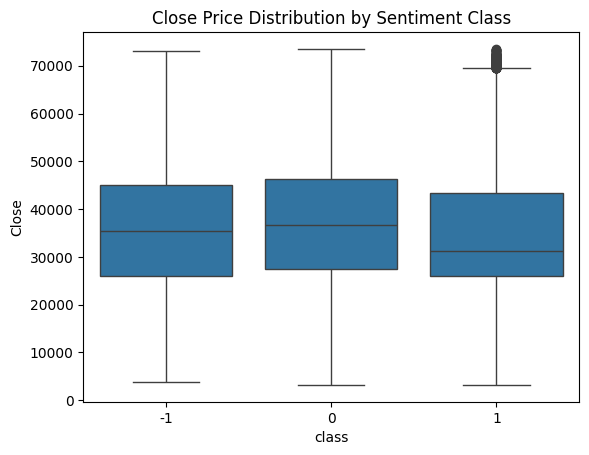

In [77]:
%matplotlib inline
import seaborn as sns

df= merged_table.to_df()
sns.boxplot(x='class', y='Close', data=df)
plt.title('Close Price Distribution by Sentiment Class')
plt.show()

In [78]:
downsample_rate = 50
date=df['date'][::downsample_rate]
polarity=df['polarity'][::downsample_rate]
close=df['Close'][::downsample_rate]

KeyError: 'date'

In [ ]:
plt.figure()
plt.plot(date,close,'k',label = 'Bitcoin price (USD)')
plt.plot(date,7000*polarity,'r',label = 'polarity')
plt.plot(date,np.zeros(len(date)))
plt.ylabel('USD')
plt.xticks(date[::100],rotation='vertical')
plt.legend()
plt.show

In [ ]:
from scipy.stats import f_oneway

negative = df[df['class'] == -1]['Close']
neutral = df[df['class'] == 0]['Close']
positive = df[df['class'] == 1]['Close']

stat, p_value = f_oneway(negative, neutral, positive)

print(f"ANOVA Statistic: {stat}, p-value: {p_value}")
if p_value < 0.05:
    print("Significant difference in Close Price across sentiment classes.")
else:
    print("No significant difference in Close Price across sentiment classes.")